In [20]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from tensorflow.keras import datasets
from matplotlib import pyplot
import tensorflow as tf
import imageio
import PIL
import glob
from IPython import display
from sklearn import metrics
import seaborn as sns

# Download dataset

In [21]:
from PIL import Image
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd 
from sklearn.metrics import accuracy_score

In [22]:
TMP_DATA_DIR = "dataset/tmp"
TMP_LABELS_DIR = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test")

TRAINING_DATA_DIR = "dataset/training"
VALIDATION_DATA_DIR = "dataset/validation"

In [23]:
#Fetch images deom GTSRB website
#Images for training
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
#Images for validation    
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
#Labels for validation
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

** Resuming transfer from byte position 276294756
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (33) HTTP server doesn't seem to support byte ranges. Cannot resume.
** Resuming transfer from byte position 88978620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (33) HTTP server doesn't seem to support byte ranges. Cannot resume.
** Resuming transfer from byte position 99620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:-- 

In [24]:
%%time
to_unpack = [
    ("GTSRB_Final_Training_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_GT.zip", TMP_LABELS_DIR)
]
 
for file, directory in to_unpack:
    print("Unzipping {} to {}...".format(file, directory))
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall(directory)

Unzipping GTSRB_Final_Training_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_GT.zip to dataset/tmp/GTSRB/Final_Test...
CPU times: user 7.42 s, sys: 2.99 s, total: 10.4 s
Wall time: 16.6 s


In [25]:
# Collect all PPM files and their labels

tmp_train_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Training/Images")

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(tmp_train_data_dir) 
               if os.path.isdir(os.path.join(tmp_train_data_dir, d))]
# Loop through the label directories and collect the data in two lists, labels and images.
ppm_files_train = []
ppm_labels_train = []
for class_directory in directories:
    label_dir = os.path.join(tmp_train_data_dir, class_directory)
    file_names = [os.path.join(label_dir, f) 
                  for f in os.listdir(label_dir) if f.endswith(".ppm")]
    # For each label, load it's images and add them to the images list.
    # And add the label number (i.e. directory name) to the labels list.
    for image_file in file_names:
        ppm_files_train.append(image_file)
        ppm_labels_train.append(class_directory)
        
# Let's have it sorted for better debugging.
ppm_files_train.sort()
ppm_labels_train.sort()

In [26]:
%%time
# Convert
# from: dataset/Final_Training/Images/00000/00000_00000.ppm
# to:   dataset/training/00000/00000_00000.jpg

for ppm_file, label in zip(ppm_files_train, ppm_labels_train):
    image = Image.open(ppm_file)
    directory = os.path.join(TRAINING_DATA_DIR, label)
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    image.save(os.path.join(directory, image_filename))

CPU times: user 10.3 s, sys: 2.43 s, total: 12.7 s
Wall time: 12.8 s


In [27]:
# Print all categories with example image for each of them.
preprocessed_training_dirs = [d for d in os.listdir(TRAINING_DATA_DIR) 
               if os.path.isdir(os.path.join(TRAINING_DATA_DIR, d))]
preprocessed_training_dirs.sort()

train_images = []
for training_dir in preprocessed_training_dirs:
    train_images.append(os.path.join(TRAINING_DATA_DIR, training_dir, "00000_00000.jpg"))

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/256)
image_data = image_generator.flow_from_directory(str(TRAINING_DATA_DIR), target_size=(32, 32))

for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Found 39209 images belonging to 43 classes.
Image batch shape:  (32, 32, 32, 3)
Label batch shape:  (32, 43)


In [28]:
#Load testing set
tmp_validation_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test/Images")

In [29]:
%%time

tmp_validation_data_files = [f for f in os.listdir(tmp_validation_data_dir) if f.endswith(".ppm")]
test_images = []

#export as JPGs
for ppm_file in tmp_validation_data_files:
    image_dir = os.path.join(tmp_validation_data_dir, ppm_file) 
    image = Image.open(image_dir)
    directory = VALIDATION_DATA_DIR
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)
        
    final_image = os.path.join(directory, image_filename)
    image.save(final_image)

    test_images.append(final_image)
    test_images.sort()
    
print("Validation images count:", len(test_images))

Validation images count: 12630
CPU times: user 5.49 s, sys: 863 ms, total: 6.35 s
Wall time: 6.39 s


# Load data

In [30]:
from skimage import color, exposure, transform
from skimage import io
import os
import glob
import matplotlib.image as mpimg

def preprocess_img(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]

    # rescale to standard size
    img = transform.resize(img, (32, 32))

    return img


def get_class(img_path):
    return int(img_path.split(os.sep)[-2])

In [31]:
root_dir = 'dataset' + os.sep + 'training' + os.sep

imgs = []
labels = []

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.jpg'))

np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    img = preprocess_img(mpimg.imread(img_path))
    label = get_class(img_path)
    imgs.append(img)
    labels.append(label)

X = np.array(imgs, dtype='float32')
# Make one hot targets
Y = np.eye(43, dtype='uint8')[labels]

print(len(X))

# Normalize pixel values to be between 0 and 1
X = X / 255.0

# Split data into training and validation (test) set
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

39209


31367


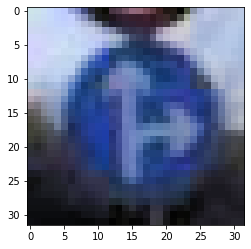

In [32]:
print(len(train_images))
image = train_images[100]

pyplot.imshow(image[:, :, :]*255)

# Generate data

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input
 

# Load model
generator = load_model('trained_generator_model.h5')
# Generate latent points
latent_points = generate_latent_points(100, 5000)
# Generate images
generated_images = generator.predict(latent_points)
print(generated_images.shape)

# Show generated data
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(generated_images[i])
plt.show()

# Train CNN model

In [ ]:
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Create the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))
model.summary()

# Compile and train the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Test the model on the dataset
history = model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels))

# Evaluate the model: accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('CNN accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Evaluate the model: loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('CNN loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = new_model.evaluate(test_images, test_labels, verbose=2)

print(test_acc)

# Predict labels for generated data

In [ ]:
# Predict labels of generated data
predictions = model.predict(generated_images)
print(predictions.shape)

# Show predictions

In [ ]:
labelNames = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for tracks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for track', 'Brock',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for track']

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(generated_images[i])
    plt.xlabel(labelNames[np.argmax(predictions[i])] + ' (' + str(np.amax(predictions[i])) + ')')
plt.show()

# Remove uncertain images

In [ ]:
print(train_images.shape)

new_train_images = []
new_train_labels = []

for i, image in enumerate(generated_images):
  # Get label predictions for generated image
  prediction = predictions[i]
  # Remove label with highest score
  other_labels = np.delete(prediction, np.argmax(prediction)) 

  if np.sum(other_labels) == 0:
    new_train_images.append(image)
    new_train_labels.append(prediction)

  # Stop when 4000 generated images are added
  if len(new_train_images) == 4000:
    break


# Convert to numpy array
new_train_images = np.array(new_train_images)
new_train_labels = np.array(new_train_labels)

# Combine old training set with generated training set
extended_train_images = np.vstack([train_images, new_train_images])
extended_train_labels = np.vstack([train_labels, new_train_labels])

print(extended_train_images.shape)
  

# Test CNN with generated data

In [ ]:
# Create the new CNN model
new_model = models.Sequential()
new_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
new_model.add(layers.MaxPooling2D((2, 2)))
new_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
new_model.add(layers.MaxPooling2D((2, 2)))
new_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
new_model.add(layers.Flatten())
new_model.add(layers.Dense(64, activation='relu'))
new_model.add(layers.Dense(43, activation='softmax'))
new_model.summary()

# Compile and train the model
new_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Test the model on the dataset
history = new_model.fit(extended_train_images, extended_train_labels, epochs=50, validation_data=(test_images, test_labels))

# Evaluate the model: accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('CNN + DCGAN accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Evaluate the model: loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('CNN + DCGAN loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = new_model.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)